# Vulnerability Analysis

This notebook repeats most of the steps of Scenario Discovery, but instead of trying to identify scenarios of concern under which to _test_ policies, we seek to understand scenarios of concern to enable our Client to better understand the conditions under which the policies we propose will no longer serve them.

-------------------
## 0. Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.analysis import prim

We will use results from the final experiment run we did, which tested the final policy set against each of the 3933 scenarios from our original DFE that fall within our initial PRIM box.

In [2]:
input_filename = './output/vulnerability_results__3933_scenarios'
results = load_results(input_filename + '.tar.gz')

In [3]:
experiments, outcomes = results
experiments.shape

(15732, 53)

In [4]:
experiments.head(3)

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A3_DikeIncrease_t2,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,scenario,policy,model
0,245.492589,0.730879,1.5,103.700541,0.811144,1.5,212.666805,0.966618,1.5,51.327441,...,0,10,7,0,5,0,0,0,s91325_p86,dikesnet
1,262.554875,0.969102,10.0,280.377067,0.526979,10.0,187.570341,0.696104,1.0,64.726114,...,0,10,7,0,5,0,0,1,s91325_p86,dikesnet
2,275.708351,0.572317,1.0,265.693511,0.420025,1.5,121.947334,0.759597,10.0,272.023678,...,0,10,7,0,5,0,0,2,s91325_p86,dikesnet


---------------------------------------

## 1. Visual Analysis

Since these runs include multiple policies, we can compare how each policy behaves under the large scenario set by looking at distributions of the generated outcomes. This can help us understand whether any of the policies are significantly stronger than others, and might provide context later on when studying how their uncertainties contribute to their outcomes.

Here, we will save a performance threshold, just as we did in Scenario Discovery. Since this is already a subset of scenarios of high concern, we will have a looser restriction, and take any case where damages in Dike Ring 4 are worse than the 75th percentile value.

In [5]:
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths']
ooi = outcomes_of_interest[0]

In [6]:
sns.set_style('darkgrid')

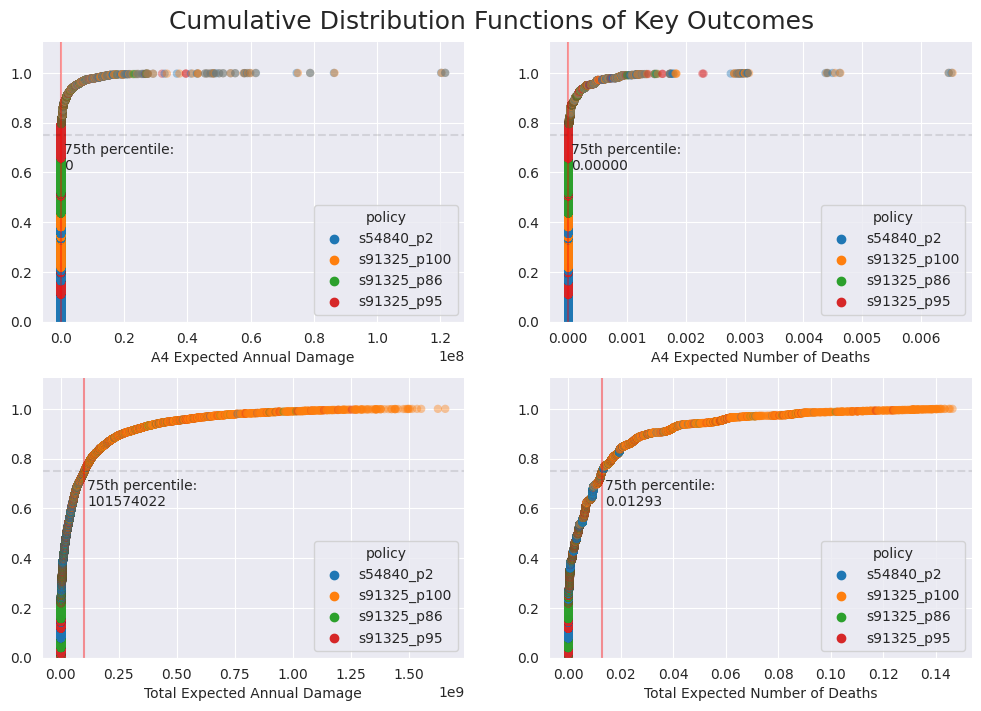

In [7]:
N = experiments.shape[0]
performance_threshold = None

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(outcomes_of_interest, axs.ravel()):
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N)/N
    df = df.reset_index()
    
    # Plot
    sns.scatterplot(data=df, x=col, y='y', hue='policy',
                    legend=True, linewidth=0,
                    alpha=0.4, palette='tab10', ax=ax)

    # Plot line at 75th percentile
    q3 = int(N*0.75)
    ax.axhline(q3/N, color='k', alpha=0.1, ls='--')
    ax.axvline(df[col][q3], label=str(df[col][q3]),
               color='r', alpha=0.4)
    
    # Label line with 75th percentile value
    annotation_point = int(N*0.61)/N # tested to line up with a gridline
    if col.split('_')[-1] == 'Deaths':
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.5f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.0f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    
    # Save performance threshold (75th percentile of outcome of interest)
    if (col == ooi):
        performance_threshold = df[col][q3]

    # Set up graph
    sns.despine(ax=ax)
    col_name = ' '.join(col.split('_'))
    ax.set(xlabel=col_name, ylabel=None, ylim=[0, 1.125])

plt.suptitle(f'Cumulative Distribution Functions of Key Outcomes',
             fontsize=18, y=0.92)
plt.savefig(f'img/vulnerability__CDFs.png')
plt.show()

From these graphs we can see that, under the already-dangerous scenarios being studied here, one of the policies (s91325_p100) tends to have a much longer tail and produce higher damages than the other policies. This could indicate that this policy is signficantly more vulnerable to extremes in the uncertainty space than others the others.

We can also see that the 75th percentile value of Expected Annual Damage in Dike Ring 4 is 0. This means that these four policies keep damage in our Client's region to 0 in at least 75% of scenarios. Combining this with the visual recognition that one policy tends to be worse than the others, this percentage is could be higher for the other three policies (though the stark difference is less notable in Dike Ring 4).

This allows an interesting analysis: when we move to our PRIM algorithm in the next step, we will be searching for a space that defines all scenarios where, even under the strong policies we have discovered and are presenting, there are _still_ damages expected in Dike Ring 4. This is truly a subspace of great concern to the Client.

-----------------------------------

## 2. Scenario Discovery -- Subspace Discovery with PRIM

We can run PRIM as we did in `Scenario Discovery.ipynb`, with our binary threshold based off of seeing _any_ damages in Dike Ring 4. The resultant box will define a subspace of concern for the Client even _if_ they adopt our policy.

In [8]:
uncertainties = ['A0_ID_flood_wave_shape', 'A1_Bmax', 'A1_Brate', 'A1_pfail', 'A2_Bmax',
                 'A2_Brate', 'A2_pfail', 'A3_Bmax', 'A3_Brate', 'A3_pfail', 'A4_Bmax',
                 'A4_Brate', 'A4_pfail', 'A5_Bmax', 'A5_Brate', 'A5_pfail',
                 'discount_rate_0', 'discount_rate_1', 'discount_rate_2',]

In [9]:
prim_alg = prim.setup_prim(results,
                           classify=lambda y: y[ooi] > performance_threshold,
                           threshold=0.75,
                           incl_unc=uncertainties,
                           mass_min=0.01
                           )

# Run PRIM search algorithm once
box1 = prim_alg.find_box()

We will use the Workbench's tools as we did for initial scenario discovery. Since we are looking for a box that describes scenarios of true concern, we will set a stricter requirement for coverage and density.

In [10]:
sns.set_style('whitegrid')

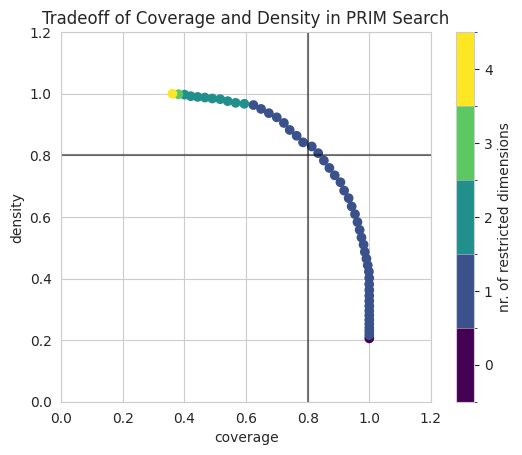

In [11]:
box1.show_tradeoff()

plt.hlines(y=[0.80], xmin=0, xmax=1.2, colors='k', alpha=0.5)
plt.vlines(x=[0.80], ymin=0, ymax=1.2, colors='k', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search')
plt.savefig('img/vulnerability__prim_trajectory.png')
plt.show()

Again we see roughly 2 cases that meet our requirements.

In [12]:
candidates = box1.peeling_trajectory
candidates = candidates[(candidates.coverage > 0.80)
                         & (candidates.density > 0.80)]
candidates

,coverage,density,id,mass,mean,res_dim
30,0.834054,0.807117,30,0.212560,0.807117,1
31,0.813350,0.828715,31,0.201882,0.828715,1


This time, we will select the one with higher coverage: since all of these scenarios are of concern in some way, we are less concerned about "false positives", as even unmarked scenarios included in the PRIM box might be of concern. Instead, we'd like to capture as many scenarios that got marked as possible.

In [13]:
best_box = candidates[candidates.coverage
                      == candidates.coverage.max()]
best_box_idx = int(best_box.index[0])

box1.select(best_box_idx)
best_box_idx

30

This bounding box only restricts in one dimension (which you can likely guess). 

In [14]:
sns.set_style('whitegrid')

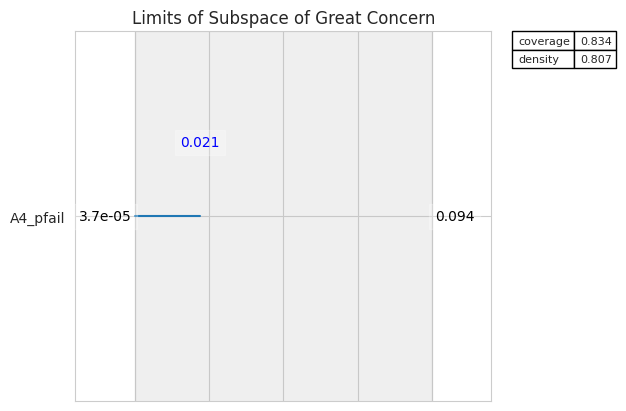

In [15]:
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Limits of Subspace of Great Concern')
plt.savefig('img/vulnerability__prim_boundary.png')
plt.show()

Indeed, to restrict to the scenarios of _absolute most concern_, as we have, all you have to do is studying the uncertainty space with a _very_ small `A4_pfail` value (meaning a very high likelihood of dikes in Dike Ring 4 not withstanding a flood). 

In [16]:
sns.set_style('white')

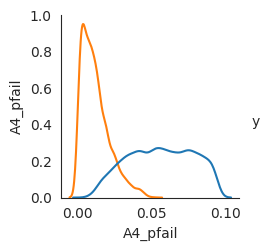

In [17]:
box1.show_pairs_scatter()
plt.savefig('img/vulnerability__prim_pairs_scatter.png')
plt.show()

This KDE shows the stark limitations of the cases we marked as scenarios of concern in this final process, and how densely they are located at low `A4_pfail`. 

Though it seems this result has limited application, it is not necessarily that way. Either the Client or the Province of Overijssel may have some internal modeling about how their dikes weaken with time. Hopefully, these models are data-forward and assess how the future probability a dike fails in the case of a flooding event changes due to real-world water level data as we collect it each year. If that is the case, then these actors probably have an idea of how long it will take for a dike to weaken to the point of nearing this `A4_pfail` value. They also have likely have some statistical models indicating the likelihood that the dike is this weak as-is, as this could be considered a random variable due to variations in the construction process. Combining this uncertainty space analysis with those figures the Client may have access to (or may commission studies to estimate) can help the client understand whether they should invest in other things instead of or alongside the policies we propose, such as dike maintenance. Or, alternatively, this could help the client implement a dike maintenance plan, on the condition that the proposed policy is adopted by the rest of the decision arena.

In [18]:
limits = box1.box_lims[best_box_idx]
limits

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,A4_pfail,A4_Brate,A5_Bmax,A5_pfail,A5_Brate,discount_rate_0,discount_rate_1,discount_rate_2,A0_ID_flood_wave_shape
0,30.079064,0.369259,"{1.5, 10.0, 1.0}",30.048476,0.123509,"{1.5, 10.0, 1.0}",30.007795,0.247171,"{1.5, 10.0, 1.0}",30.063494,0.000037,"{1.5, 10.0, 1.0}",30.188075,0.000166,"{1.0, 10.0, 1.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",0
1,349.970645,0.999886,"{1.5, 10.0, 1.0}",349.948428,0.999964,"{1.5, 10.0, 1.0}",349.975190,0.999860,"{1.5, 10.0, 1.0}",349.963706,0.020700,"{1.5, 10.0, 1.0}",349.980059,0.999943,"{1.0, 10.0, 1.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",132


--------------------------

## 3. Filter, Sort, and Save Outputs

For completeness and to provide the Client with full information, we will filter the set of scenarios that fall within this new subspace of great concern. These scenarios can be used for worst-case modelling in the future, especially if one of the proposed policies is adopted.

In [19]:
# Create a new dataframe of experiments & their outcomes
# and track whether they fall outside the PRIM box boundary
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]

combined_df['Within Limit'] = True

print(combined_df.shape)
combined_df.head(3)

(15732, 67)


,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Within Limit
0,245.492589,0.730879,1.5,103.700541,0.811144,1.5,212.666805,0.966618,1.5,51.327441,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,3.171744e+08,0.000000e+00,0.000000,True
1,262.554875,0.969102,10.0,280.377067,0.526979,10.0,187.570341,0.696104,1.0,64.726114,...,0.0,0.0,285240.387070,0.000016,8.062438e+06,0.000684,3.171744e+08,8.347678e+06,0.000700,True
2,275.708351,0.572317,1.0,265.693511,0.420025,1.5,121.947334,0.759597,10.0,272.023678,...,0.0,0.0,280561.829239,0.000016,4.829620e+07,0.004058,3.171744e+08,4.857676e+07,0.004074,True


In [20]:
# Apply PRIM constraint in each dimension
for idx, row in combined_df.iterrows():
    for unc in limits:
        if (type(limits.loc[0, unc]) == set):
            if row[unc] not in limits.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limits.loc[0, unc] or row[unc] > limits.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [21]:
# Use new column to filter the rows, then drop this column
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
print(f'{combined_df.shape[0]} scenarios remain in the PRIM box.')

3344 scenarios remain in the PRIM box.


We have filtered down to almost 4000 scenarios. This makes sense, as it is roughly 10% of the set we started with (the scenarios that produced any damage to A4 under the status quo). 4000 scenarios is quite a few, so the next step will be to select a diverse, representative set of 3-5 of these scenarios that we can carry forward and use in our policy search. The generation of candidate sets and the assessment of set diversity will be done in [open_exploration__scenario_diversity_scoring.py](open_exploration__scenario_diversity_scoring.py). To support this set generation and filtering, we will save the filtered, combined experiments and outcomes DataFrame in sorted order by outcome 'A4 Expected Annual Damage'.

In [22]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head(3)

,A1_Bmax,A1_pfail,A1_Brate,A2_Bmax,A2_pfail,A2_Brate,A3_Bmax,A3_pfail,A3_Brate,A4_Bmax,...,A2_Expected_Number_of_Deaths,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
8374,130.939712,0.746688,1.0,254.050146,0.299472,1.0,81.734104,0.705162,1.0,126.542838,...,0.00000,3.586298e+06,0.000781,1.215047e+08,0.006472,0.000000e+00,0.000000,1.982227e+08,1.250910e+08,0.007253
12307,130.939712,0.746688,1.0,254.050146,0.299472,1.0,81.734104,0.705162,1.0,126.542838,...,0.00059,0.000000e+00,0.000000,1.214597e+08,0.006467,5.856854e+07,0.005999,1.686922e+08,1.851306e+08,0.013056
12200,65.974096,0.897180,10.0,60.535595,0.954783,1.0,169.459071,0.551625,10.0,260.615224,...,0.00000,3.472732e+06,0.000761,1.203532e+08,0.006534,0.000000e+00,0.000000,1.686922e+08,1.238260e+08,0.007294


In [23]:
output_filename = input_filename + '__prim_filtered.csv'
combined_df.to_csv(output_filename, index=True)